# TS4

Alumnas: Naudeau Nahiara, Maria Serena Gil

## Introducción

El procesamiento digital de señales (DSP) nos permite analizar, manipular y extraer información de señales discretas en el tiempo. Una de las aplicaciones fundamentales del DSP es la estimación de parámetros de señales contaminadas por ruido, como la amplitud y la frecuencia.


### DFT, ventana y transformada ventaneada
El uso de ventanas reduce el efecto de leakage, que aparece cuando la frecuencia de la señal no coincide exactamente con un bin de la DFT.

Efectos principales de la ventana:
- Resolución (ancho del main-lobulo): las ventans que tienen un main-lóbulo mas estrecho dan mejor resolución en frecuencia, las ventanas con un main-lóbulo ancho degradan resolución.
- Sidelobes: las ventans que tienen un sidelobe bajo reducen el desparramiento espectral (spectral leakage) y ayudan a detectar tonos débiles (amplitud baja) cercanos a tonos fuertes (amplitud fuerte).
- Atenuación de amplitud: la ventana reduce la amplitud observada del pico; hay que corregirla con la ganancia coherente que es:
$$
G_c = \frac{1}{N} \sum_{n=0}^{N-1} w[n]
$$


Sea una ventana $w[n]$ de longitud $N$ y $x[n]$ la señal con rudio, la DFT  de la señal ventaneada es:
$$
X_w[k] = \sum_{n=0}^{N-1} x[n] \, w[n] \, e^{-j 2\pi \frac{k n}{N}}, 
\qquad k = 0, 1, \dots, N-1
$$

### Desplazamiento de Frecuencia $f_r \sim \mathcal{U}(a,b)$
Esto significa que $f_r$ tiene distribución uniforme entre a y b, por lo que todos los valores de frecuencia posibles dentro de este rango $[a, b]$ tienen la misma probabilidad de aparecer, creando una señal sin un pico o sesgo hacia ciertas frecuencias

### Estimador de amplitud
$$ \hat{a}_i^1 = | X_w^i (\Omega_0) | = |\mathcal{F} \{ x(n) \cdot w_i(n) \} | $$
- $\hat{a}_i^1$: Es la estimación de la amplitud de la señal en el índice $i$.
- $X_w^i(\Omega_0)$: Es el valor de la transformada de Fourier de la señal $x[n]$ multiplicada por la ventana $w_i[n]$ en la frecuencia $\Omega_0$. 
- $\mathcal{F}$: La transformada de Fourier.
- $x(n)$: Representa la señal de entrada, que puede ser cualquier señal discreta en el tiempo.
- $w_i(n)$: Es la ventana aplicada a la señal $x(n)$.

El estimador de amplitud en señales ventaneadas tiene como objetivo obtener una estimación de la amplitud de una señal dentro de un intervalo de tiempo determinado. La idea detrás de esto es que, al aplicar una ventana a la señal, se puede analizar un pedacito de la señal para obtener una estimación de su comportamiento en ese pedacito, sin que la ventana afecte significativamente el resultado.

### Estimador de frecuencia
$$ \hat{\Omega}_1^i = \arg \max_f \left\{ | X_w^i (\Omega) | \right\} $$

- $\hat{\Omega}_1^i$: Es la estimación de la frecuencia correspondiente a la señal en el índice $i$.
- $\arg \max_f$: Esto indica que estamos buscando el valor de la frecuencia $\Omega$ que maximiza el valor absoluto de $X_w^i (\Omega)$.
- $X_w^i(\Omega)$: La transformada de Fourier de la señal $x(n)$ multiplicada por la ventana $w_i(n)$ en la frecuencia $\Omega$ (el espectro de la señal en el dominio de la frecuencia)
El objetivo de esta fórmula es encontrar la frecuencia que corresponde a la máxima magnitud en el espectro de la señal ventaneada.

### Sesgo y Varianza
Para evaluar el desempeño de un estimador, se consideran dos métricas:
- Sesgo: mide la diferencia entre el valor esperado del estimador y el valor verdadero del parámetro.
$$
s_a = \mathbb{E}\{\hat{a}_0\} - a_0
$$
Un sesgo cercano a cero indica que el estimador esta desesgado o exacto en promedio.
- Varianza: mide la dispersión de las estimaciones alrededor de su valor esperado.
$$
v_a = \mathrm{var}\{\hat{a}_0\} = \mathbb{E} \left\{ \left( \hat{a}_0 - \mathbb{E}\{\hat{a}_0\} \right)^2 \right\}
$$
Una varianza baja indica que el estimador es consistente y preciso en cada realización.

### Relación Señal-Ruido (SNR)
La SNR es una métrica que cuantifica la proporción de energía de la señal útil respecto a la energía del ruido que la contamina:
$$
\text{SNR}_{\text{lineal}} = \frac{P_{\text{señal}}}{P_{\text{ruido}}}
$$
En decibelios (dB), se define como:
$$
\text{SNR}_{\text{dB}} = 10 \cdot \log_{10}\left(\frac{P_{\text{señal}}}{P_{\text{ruido}}}\right)
$$
Donde $P_{señal}$ es la potencia de la sinusoide y $P_{ruido}$ es la potencia del ruido aditivo

Efecto de la SNR en la estimación
- SNR baja (3 dB en mi caso de estudio): la potencia del ruido es comparable a la de la señal, lo que genera estimaciones más inestables y ruidosas. Se espera alta varianza en los estimadores y mayor dificultad para identificar la frecuencia máxima en la DFT.
- SNR alta (10 dB en mi caso de estudio): la señal domina sobre el ruido, produciendo estimaciones más precisas y confiables. La varianza disminuye y el sesgo se hace más evidente, ya que el ruido ya no “promedia” el resultado.

# Código

### Para SNR= 10dB:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft
import scipy.signal as sig
win = sig.windows


# Parámetros
N = 1000      #muestras
R = 200       #realizaciones
fs = N        #frecuencia de muestreo 
f0 = fs / 4   #frecuencia de la senoidal
resolucionEspectral=fs/N
frecRandom= np.random.uniform(low=-2, high=2, size=R)*resolucionEspectral #ojo que es un vector
frecRandom = frecRandom.reshape(1, R)

#tiempo en vector y matriz
Ts = 1/fs
t = np.linspace(0, (N-1)*Ts, N)            #vector de tiempo 
t_mat = np.tile(t.reshape(N, 1), (1, R))   #matriz 1000x200 (columnas = realizaciones)

#señal senoidal en matriz
a0 = np.sqrt(2)
señalMatriz = a0 * np.sin(2*np.pi*(f0+frecRandom)*t_mat)   # matriz 1000x200

def SNRvarianza(señal, SNRdb):
    potSeñal = np.mean(señal**2)
    return potSeñal / (10**(SNRdb / 10))

Rvar = SNRvarianza(señalMatriz, 10)

#rudio pero matriz
ruidoMatriz = np.random.normal(0, np.sqrt(Rvar), (N, R))

#señal+ruido
señalConRuidoMatriz = señalMatriz + ruidoMatriz

#Ventanas

#---------------RECTANGULAR---------------#

señalConRuidoFFT = fft(señalConRuidoMatriz, axis=0)/N #(osea sin ventanita)
espectroRect = 10*np.log10(2*np.abs(señalConRuidoFFT)**2)

#---------------HAMMING---------------#
hamming = win.hamming(N).reshape(N,1)
señalRuidosaHamming = señalConRuidoMatriz * hamming
señalRuidosaHammingFFT = fft(señalRuidosaHamming, axis=0)/N
espectroHamming = 10*np.log10(2*np.abs(señalRuidosaHammingFFT)**2)


#---------------FLATTOP---------------#
flattop = win.flattop(N).reshape(N,1)
señalRuidosaFlattop = señalConRuidoMatriz * flattop
señalRuidosaFlattopFFT = fft(señalRuidosaFlattop, axis=0)/N
espectroFlattop = 10*np.log10(2*np.abs(señalRuidosaFlattopFFT)**2)


#---------------BLACKMANHARRIS---------------#
blackmanH = win.blackmanharris(N).reshape(N,1)
señalRuidosaBlackH = señalConRuidoMatriz * blackmanH
señalRuidosaBlackHFFT = fft(señalRuidosaBlackH, axis=0)/N
espectroBlackmanH = 10*np.log10(2*np.abs(señalRuidosaBlackHFFT)**2)


### Estimador de amplitud


ESTIMADOR DE AMPLITUD SNR:10dB
--------------------------------
VENTANA         SESGO_AMP      VAR_AMP
Rectangular     -1.0363      0.1118
Flattop         -1.2145      0.0005
Blackman-Harris -1.1687      0.0082
Hamming         -1.1421      0.0342


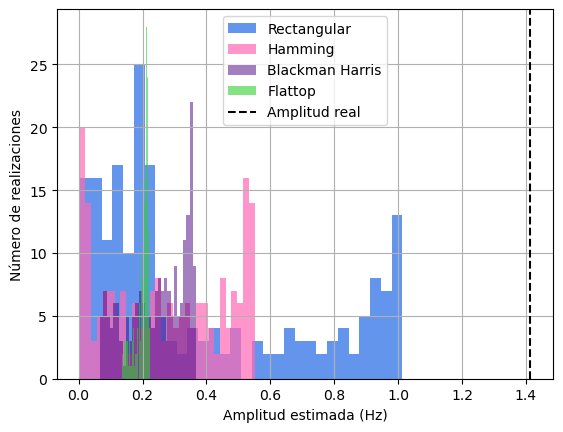

In [8]:
#RECTANGULAR
a2 = 10*np.log10((np.abs(señalConRuidoFFT[N//4,:])**2)*2)  #estimador
a2_lin = np.sqrt(10**(a2/10))  # paso de dB a valor a lineal

a2prom = np.mean(a2_lin) #promedio de las amplitudes estimadas
sesgo_a2 = a2prom - a0  
var_a2 = np.var(a2_lin) 

#HAMMING
a3 = 10*np.log10((np.abs(señalRuidosaHammingFFT[N//4,:])**2)*2)  #estimador 
a3_lin = np.sqrt(10**(a3/10))

a3prom = np.mean(a3_lin)
sesgo_a3 = a3prom - a0
var_a3 = np.var(a3_lin)

#FLATTOP
a4 = 10*np.log10((np.abs(señalRuidosaFlattopFFT[N//4,:])**2)*2)  #estimador 
a4_lin = np.sqrt(10**(a4/10))

a4prom = np.mean(a4_lin)
sesgo_a4 = a4prom - a0
var_a4 = np.var(a4_lin)

#BLACKMANHARRIS
a5 = 10*np.log10((np.abs(señalRuidosaBlackHFFT[N//4,:])**2)*2)  #estimador
a5_lin = np.sqrt(10**(a5/10))

a5prom = np.mean(a5_lin)
sesgo_a5 = a5prom - a0
var_a5 = np.var(a5_lin)


print("\nESTIMADOR DE AMPLITUD SNR:10dB")
print("--------------------------------")
print("VENTANA         SESGO_AMP      VAR_AMP")
print(f"Rectangular     {sesgo_a2:.4f}      {var_a2:.4f}")
print(f"Flattop         {sesgo_a4:.4f}      {var_a4:.4f}")
print(f"Blackman-Harris {sesgo_a5:.4f}      {var_a5:.4f}")
print(f"Hamming         {sesgo_a3:.4f}      {var_a3:.4f}")


#HISTOGRAMAS
bins = 30

# ----------HISTOGRAMA DE AMPLITUD---------- #
plt.figure(1)
plt.hist(a2_lin,label='Rectangular', bins = bins, color = 'cornflowerblue')
plt.hist(a3_lin,label='Hamming', alpha = 0.7, bins = bins, color = 'hotpink')
plt.hist(a5_lin,label='Blackman Harris', alpha = 0.5, bins = bins, color = 'indigo')
plt.hist(a4_lin,label='Flattop', alpha = 0.6, bins = bins, color = 'limegreen')
plt.axvline(a0, color="k", linestyle="--", label="Amplitud real")
plt.xlabel("Amplitud estimada (Hz)")
plt.ylabel("Número de realizaciones")
plt.legend()
plt.grid(True)
plt.show()

$$
\begin{array}{|c|c|c|}
\hline
\textbf{Estimación de Amplitud} & s_a & v_a \\ 
\hline
\text{Rectangular} &  -1.036 & 0.1118 \\ 
\hline
\text{Flattop} & -1.214 & 0.0005 \\ 
\hline
\text{Blackman Harris} & -1.168 & 0.0082 \\ 
\hline
\text{Hamming} & -1.142 & 0.0342 \\ 
\hline
\end{array}
$$

Al ver los histogramas podemos notar como la distribución de las estimaciones se concentra al rededor del valor esperado.
La ventana Flattop fue la que produjo las mejores estimaciones, viendo valores muy cercanos al cero para el sesgo y la varianza. En el caso de cuando no se uso ventana (rectangular) este es donde se puede ver una mayor dispersión de las estimaciones dando los valores más altos para sesgo y varianza. Las ventanas Blackman Harris y Hamming estuvieron algo parecidas con una varianza y sesgo moderado.

En todos los sesgos calculados se obtuvieron numeros negativos, esto es concecuencia del scalloping loss (festeado), es cuando la frecuencia de la señal cae entre dos bins de la FFT, parte de la energía de la sinusoide “se esparce” hacia los bins adyacentes, y la magnitud en el bin central subestima la amplitud real.

### Estimador en frecuencia


ESTIMADOR DE FRECUENCIA SNR:10dB
VENTANA          SESGO_FREQ        VAR_FREQ
Rectangular      -0.0350        1.3138
Flattop          -0.0400        1.2584
Blackman-Harris  -0.0300        1.3091
Hamming          -0.0350        1.3138


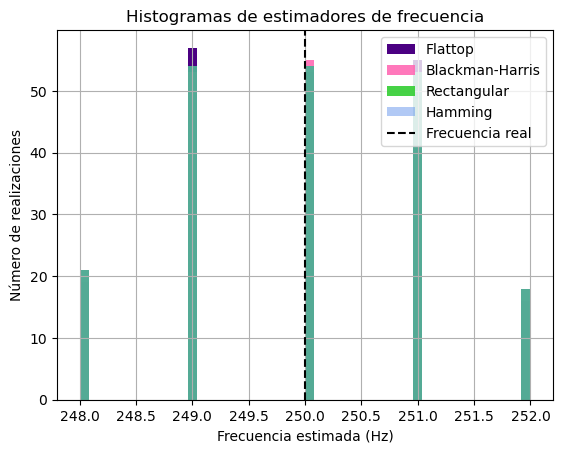

In [17]:
# Vector de frecuencias (Hz)
frecuencias = np.fft.fftfreq(N, d=1/fs)
frecuenciasPositivas = frecuencias[:N//2]   # solo la mitad positiva asi no tengo los dos picpos

# ---------------- Rectangular ---------------- #
indiceMaximoRectangular = np.argmax(np.abs(señalConRuidoFFT[:N//2, :]), axis=0)
omega1 = frecuenciasPositivas[indiceMaximoRectangular]   # estimador de frecuencia
sesgoOmega1 = np.mean(omega1) - f0
varianzaOmega1 = np.var(omega1)

# ---------------- Hamming ---------------- #
indiceMaximoHamming = np.argmax(np.abs(señalRuidosaHammingFFT[:N//2, :]), axis=0)
omega2 = frecuenciasPositivas[indiceMaximoHamming]
sesgoOmega2 = np.mean(omega2) - f0
varianzaOmega2 = np.var(omega2)

# ---------------- Flattop ---------------- #
indiceMaximoFlattop = np.argmax(np.abs(señalRuidosaFlattopFFT[:N//2, :]), axis=0)
omega3 = frecuenciasPositivas[indiceMaximoFlattop]
sesgoOmega3 = np.mean(omega3) - f0
varianzaOmega3 = np.var(omega3)

# ---------------- Blackman-Harris ---------------- #
indiceMaximoBlackmanHarris = np.argmax(np.abs(señalRuidosaBlackHFFT[:N//2, :]), axis=0)
omega4 = frecuenciasPositivas[indiceMaximoBlackmanHarris]
sesgoOmega4 = np.mean(omega4) - f0
varianzaOmega4 = np.var(omega4)

#---------------------------TABLA DE RESULTADOS---------------------------#
print("\nESTIMADOR DE FRECUENCIA SNR:10dB")
print("VENTANA          SESGO_FREQ        VAR_FREQ")
print(f"Rectangular      {sesgoOmega1:.4f}        {varianzaOmega1:.4f}")
print(f"Flattop          {sesgoOmega3:.4f}        {varianzaOmega3:.4f}")
print(f"Blackman-Harris  {sesgoOmega4:.4f}        {varianzaOmega4:.4f}")
print(f"Hamming          {sesgoOmega2:.4f}        {varianzaOmega2:.4f}")

#---------------------------HISTOGRAMA DE FREC---------------------------#
plt.figure(2)
plt.hist(omega3, bins=50, label="Flattop", color = 'indigo')
plt.hist(omega4, bins=50, alpha=0.9, label="Blackman-Harris", color = 'hotpink')
plt.hist(omega1, bins=50, alpha=0.9, label="Rectangular", color = 'limegreen')
plt.hist(omega2, bins=50, alpha=0.5, label="Hamming", color = 'cornflowerblue')
plt.axvline(f0, color="k", linestyle="--", label="Frecuencia real")
plt.xlabel("Frecuencia estimada (Hz)")
plt.ylabel("Número de realizaciones")
plt.title("Histogramas de estimadores de frecuencia")
plt.legend()
plt.grid(True)
plt.show()

$$
\begin{array}{|c|c|c|}
\hline
\textbf{Estimación de Frecuencia} & s_a & v_a \\ 
\hline
\text{Rectangular} & -0.035 & 1.313 \\ 
\hline
\text{Flattop} & -0.040 & 1.258 \\ 
\hline
\text{Blackman Harris} & -0.030 & 1.309 \\ 
\hline
\text{Hamming} & -0.035 & 1.313 \\ 
\hline
\end{array}
$$

Los histogramas nos muestran como, debido a la resolución discreta de la FFT, las estimaciones se agrupan en bins cercanos a la frecuencia real $f_0$. 
Los sesgos calculados muestran que en promedio el estimador de frecuencia está centrado correctamente alrededor de la frecuencia real, y que el desplazamiento de frecuencia aleatorio $f_r$ y el ruido no introducen un sesgo sistemático apreciable, aunque tambien tiene un poco de lo que es scalloping loss al igual que con el estimador de amplitud.
Las varianzas tampoco son valores muy grandes pero aun asi se refleja una variabilidad introducida por $f_r$. La ventana Flattop, devuelta, fue la que menor varianza y sesgo presentó, aunque no muy significativamente.

### Para SNR= 3dB:


ESTIMADOR DE AMPLITUD SNR:10dB
--------------------------------
VENTANA         SESGO_AMP      VAR_AMP
Rectangular     -1.0334      0.1116
Hamming         -1.1402      0.0335
Flattop         -1.2140      0.0005
Blackman-Harris -1.1681      0.0082


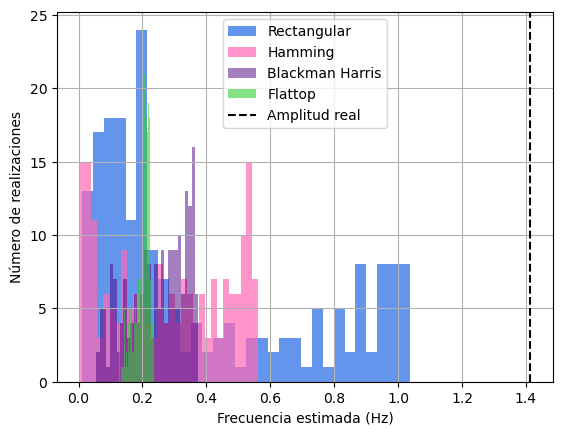


ESTIMADOR DE FRECUENCIA SNR:10dB
VENTANA          SESGO_FREQ        VAR_FREQ
Rectangular      -0.0350        1.2938
Hamming          -0.0400        1.2984
Flattop          -0.0150        1.4448
Blackman-Harris  -0.0350        1.2938


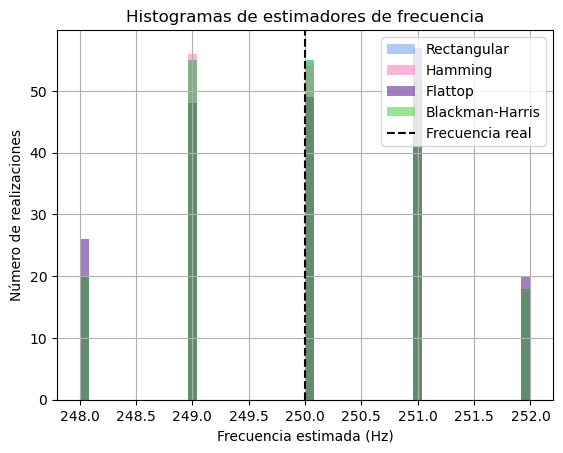

In [18]:
Rvar = SNRvarianza(señalMatriz, 3)

#rudio pero matriz
ruidoMatriz = np.random.normal(0, np.sqrt(Rvar), (N, R))

#señal+ruido
señalConRuidoMatriz = señalMatriz + ruidoMatriz


#Ventanas

#---------------RECTANGULAR---------------#

señalConRuidoFFT = fft(señalConRuidoMatriz, axis=0)/N #(osea sin ventanita)
espectroRect = 10*np.log10(2*np.abs(señalConRuidoFFT)**2)

#---------------HAMMING---------------#
hamming = win.hamming(N).reshape(N,1)
señalRuidosaHamming = señalConRuidoMatriz * hamming
señalRuidosaHammingFFT = fft(señalRuidosaHamming, axis=0)/N
espectroHamming = 10*np.log10(2*np.abs(señalRuidosaHammingFFT)**2)


#---------------FLATTOP---------------#
flattop = win.flattop(N).reshape(N,1)
señalRuidosaFlattop = señalConRuidoMatriz * flattop
señalRuidosaFlattopFFT = fft(señalRuidosaFlattop, axis=0)/N
espectroFlattop = 10*np.log10(2*np.abs(señalRuidosaFlattopFFT)**2)


#---------------BLACKMANHARRIS---------------#
blackmanH = win.blackmanharris(N).reshape(N,1)
señalRuidosaBlackH = señalConRuidoMatriz * blackmanH
señalRuidosaBlackHFFT = fft(señalRuidosaBlackH, axis=0)/N
espectroBlackmanH = 10*np.log10(2*np.abs(señalRuidosaBlackHFFT)**2)


#---------------ESTIMADOR DE AMPLITUD---------------#


#RECTANGULAR
a2 = 10*np.log10((np.abs(señalConRuidoFFT[N//4,:])**2)*2)  #estimador
a2_lin = np.sqrt(10**(a2/10))  # paso de dB a valor a lineal

a2prom = np.mean(a2_lin) #promedio de las amplitudes estimadas
sesgo_a2 = a2prom - a0  
var_a2 = np.var(a2_lin) 

#HAMMING
a3 = 10*np.log10((np.abs(señalRuidosaHammingFFT[N//4,:])**2)*2)  #estimador 
a3_lin = np.sqrt(10**(a3/10))

a3prom = np.mean(a3_lin)
sesgo_a3 = a3prom - a0
var_a3 = np.var(a3_lin)

#FLATTOP
a4 = 10*np.log10((np.abs(señalRuidosaFlattopFFT[N//4,:])**2)*2)  #estimador 
a4_lin = np.sqrt(10**(a4/10))

a4prom = np.mean(a4_lin)
sesgo_a4 = a4prom - a0
var_a4 = np.var(a4_lin)

#BLACKMANHARRIS
a5 = 10*np.log10((np.abs(señalRuidosaBlackHFFT[N//4,:])**2)*2)  #estimador
a5_lin = np.sqrt(10**(a5/10))

a5prom = np.mean(a5_lin)
sesgo_a5 = a5prom - a0
var_a5 = np.var(a5_lin)


print("\nESTIMADOR DE AMPLITUD SNR:10dB")
print("--------------------------------")
print("VENTANA         SESGO_AMP      VAR_AMP")
print(f"Rectangular     {sesgo_a2:.4f}      {var_a2:.4f}")
print(f"Hamming         {sesgo_a3:.4f}      {var_a3:.4f}")
print(f"Flattop         {sesgo_a4:.4f}      {var_a4:.4f}")
print(f"Blackman-Harris {sesgo_a5:.4f}      {var_a5:.4f}")


#HISTOGRAMAS
bins = 30

# ----------HISTOGRAMA DE AMPLITUD---------- #
plt.figure(1)
plt.hist(a2_lin,label='Rectangular', bins = bins, color = 'cornflowerblue')
plt.hist(a3_lin,label='Hamming', alpha = 0.7, bins = bins, color = 'hotpink')
plt.hist(a5_lin,label='Blackman Harris', alpha = 0.5, bins = bins, color = 'indigo')
plt.hist(a4_lin,label='Flattop', alpha = 0.6, bins = bins, color = 'limegreen')
plt.axvline(a0, color="k", linestyle="--", label="Amplitud real")
plt.xlabel("Frecuencia estimada (Hz)")
plt.ylabel("Número de realizaciones")
plt.legend()
plt.grid(True)
plt.show()


#---------------ESTIMADOR DE FRECUENCIA---------------#

# Vector de frecuencias (Hz)
frecuencias = np.fft.fftfreq(N, d=1/fs)
frecuenciasPositivas = frecuencias[:N//2]   # solo la mitad positiva asi no tengo los dos picpos

# ---------------- Rectangular ---------------- #
indiceMaximoRectangular = np.argmax(np.abs(señalConRuidoFFT[:N//2, :]), axis=0)
omega1 = frecuenciasPositivas[indiceMaximoRectangular]   # estimador de frecuencia
sesgoOmega1 = np.mean(omega1) - f0
varianzaOmega1 = np.var(omega1)

# ---------------- Hamming ---------------- #
indiceMaximoHamming = np.argmax(np.abs(señalRuidosaHammingFFT[:N//2, :]), axis=0)
omega2 = frecuenciasPositivas[indiceMaximoHamming]
sesgoOmega2 = np.mean(omega2) - f0
varianzaOmega2 = np.var(omega2)

# ---------------- Flattop ---------------- #
indiceMaximoFlattop = np.argmax(np.abs(señalRuidosaFlattopFFT[:N//2, :]), axis=0)
omega3 = frecuenciasPositivas[indiceMaximoFlattop]
sesgoOmega3 = np.mean(omega3) - f0
varianzaOmega3 = np.var(omega3)

# ---------------- Blackman-Harris ---------------- #
indiceMaximoBlackmanHarris = np.argmax(np.abs(señalRuidosaBlackHFFT[:N//2, :]), axis=0)
omega4 = frecuenciasPositivas[indiceMaximoBlackmanHarris]
sesgoOmega4 = np.mean(omega4) - f0
varianzaOmega4 = np.var(omega4)

#---------------------------TABLA DE RESULTADOS---------------------------#
print("\nESTIMADOR DE FRECUENCIA SNR:10dB")
print("VENTANA          SESGO_FREQ        VAR_FREQ")
print(f"Rectangular      {sesgoOmega1:.4f}        {varianzaOmega1:.4f}")
print(f"Hamming          {sesgoOmega2:.4f}        {varianzaOmega2:.4f}")
print(f"Flattop          {sesgoOmega3:.4f}        {varianzaOmega3:.4f}")
print(f"Blackman-Harris  {sesgoOmega4:.4f}        {varianzaOmega4:.4f}")

#---------------------------HISTOGRAMA DE FREC---------------------------#
plt.figure(2)
plt.hist(omega1, bins=50, alpha=0.5, label="Rectangular", color = 'cornflowerblue')
plt.hist(omega2, bins=50, alpha=0.5, label="Hamming", color = 'hotpink')
plt.hist(omega3, bins=50, alpha=0.5, label="Flattop", color = 'indigo')
plt.hist(omega4, bins=50, alpha=0.5, label="Blackman-Harris", color = 'limegreen')
plt.axvline(f0, color="k", linestyle="--", label="Frecuencia real")
plt.xlabel("Frecuencia estimada (Hz)")
plt.ylabel("Número de realizaciones")
plt.title("Histogramas de estimadores de frecuencia")
plt.legend()
plt.grid(True)
plt.show()

Un SNR más alto (por ejemplo 10 dB) significa que la señal domina sobre el ruido, mientras que un SNR más bajo (por ejemplo 3 dB) indica que el ruido es relativamente más fuerte respecto a la señal. En este ejemplo, aunque se puso SNR = 3 dB, los resultados de los estimadores de amplitud y frecuencia prácticamente no cambiaron respecto a SNR = 10 dB, esto pasa porque la señal tiene una amplitud relativamente grande $(a_0=\sqrt{2})$ y la FFT está normalizada por N, lo que reduce la influencia del ruido en el dominio espectral. Además, el generador de ruido promedia sobre muchas realizaciones y la resolución de frecuencia es limitada, por lo que incluso un SNR más bajo no produce diferencias apreciables en la estimación de los picos de la FFT. En otras palabras, el ruido agregado sigue siendo pequeño en comparación con la magnitud de los picos espectrales, haciendo que la varianza y el sesgo de los estimadores permanezcan casi constantes.

## Bonus


ESTIMADOR DE FRECUENCIA con ZERO-PADDING (SNR=10dB)
VENTANA          SESGO_FREQ        VAR_FREQ
Rectangular      -0.0250        1.1844
Hamming          -0.0238        1.1854
Flattop          -0.0337        1.4985
Blackman-Harris  -0.0213        1.1867


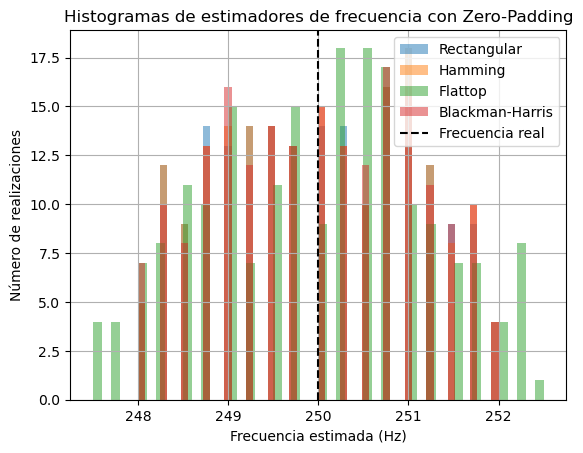

In [21]:
N_zp = 4 * N  
frecuencias_zp = np.fft.fftfreq(N_zp, d=1/fs)
frecuenciasPositivas_zp = frecuencias_zp[:N_zp//2]

# ---------------- Rectangular ---------------- #
señalConRuidoFFT_zp = fft(señalConRuidoMatriz, n=N_zp, axis=0)/N
indiceMaximoRectangular_zp = np.argmax(np.abs(señalConRuidoFFT_zp[:N_zp//2, :]), axis=0)
omega1_zp = frecuenciasPositivas_zp[indiceMaximoRectangular_zp]
sesgoOmega1_zp = np.mean(omega1_zp) - f0
varianzaOmega1_zp = np.var(omega1_zp)

# ---------------- Hamming ---------------- #
señalRuidosaHammingFFT_zp = fft(señalRuidosaHamming, n=N_zp, axis=0)/N
indiceMaximoHamming_zp = np.argmax(np.abs(señalRuidosaHammingFFT_zp[:N_zp//2, :]), axis=0)
omega2_zp = frecuenciasPositivas_zp[indiceMaximoHamming_zp]
sesgoOmega2_zp = np.mean(omega2_zp) - f0
varianzaOmega2_zp = np.var(omega2_zp)

# ---------------- Flattop ---------------- #
señalRuidosaFlattopFFT_zp = fft(señalRuidosaFlattop, n=N_zp, axis=0)/N
indiceMaximoFlattop_zp = np.argmax(np.abs(señalRuidosaFlattopFFT_zp[:N_zp//2, :]), axis=0)
omega3_zp = frecuenciasPositivas_zp[indiceMaximoFlattop_zp]
sesgoOmega3_zp = np.mean(omega3_zp) - f0
varianzaOmega3_zp = np.var(omega3_zp)

# ---------------- Blackman-Harris ---------------- #
señalRuidosaBlackHFFT_zp = fft(señalRuidosaBlackH, n=N_zp, axis=0)/N
indiceMaximoBlackmanHarris_zp = np.argmax(np.abs(señalRuidosaBlackHFFT_zp[:N_zp//2, :]), axis=0)
omega4_zp = frecuenciasPositivas_zp[indiceMaximoBlackmanHarris_zp]
sesgoOmega4_zp = np.mean(omega4_zp) - f0
varianzaOmega4_zp = np.var(omega4_zp)

# ------------------ Tabla de resultados ------------------ #
print("\nESTIMADOR DE FRECUENCIA con ZERO-PADDING (SNR=10dB)")
print("VENTANA          SESGO_FREQ        VAR_FREQ")
print(f"Rectangular      {sesgoOmega1_zp:.4f}        {varianzaOmega1_zp:.4f}")
print(f"Hamming          {sesgoOmega2_zp:.4f}        {varianzaOmega2_zp:.4f}")
print(f"Flattop          {sesgoOmega3_zp:.4f}        {varianzaOmega3_zp:.4f}")
print(f"Blackman-Harris  {sesgoOmega4_zp:.4f}        {varianzaOmega4_zp:.4f}")

# ------------------ Histogramas ------------------ #
plt.figure()
plt.hist(omega1_zp, bins=50, alpha=0.5, label="Rectangular")
plt.hist(omega2_zp, bins=50, alpha=0.5, label="Hamming")
plt.hist(omega3_zp, bins=50, alpha=0.5, label="Flattop")
plt.hist(omega4_zp, bins=50, alpha=0.5, label="Blackman-Harris")
plt.axvline(f0, color="k", linestyle="--", label="Frecuencia real")
plt.xlabel("Frecuencia estimada (Hz)")
plt.ylabel("Número de realizaciones")
plt.title("Histogramas de estimadores de frecuencia con Zero-Padding")
plt.legend()
plt.grid(True)
plt.show()

Para mejorar la resolución espectral de la FFT se aplicó zero-padding, extendiendo la señal de $N=1000$ muestas a $N_{zp}=4000$ muestras. Esto reduce el paso en frecuencia de df=1Hz a df=0,25Hz, permitiendo que el pico de la sinusoide caiga más cerca de un bin exacto de la FFT y reduciendo parcialmente el efecto de scalloping loss. En los resultados, los valores promedio de sesgo y varianza de los estimadores de frecuencia prácticamente no cambian, ya que la dispersión sigue estando dominada por el desplazamiento aleatorio de frecuencia y el ruido aditivo. Sin embargo, los histogramas muestran distribuciones más finas y detalladas, con los picos mejor centrados y más continuos, lo que permite visualizar con mayor precisión la dispersión de las estimaciones alrededor de la frecuencia real $f_0$.